# Purple_CCF calculation in lung sample

In [1]:
# Needed basic packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook
from matplotlib_venn import venn3
import time

In [2]:
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

In [3]:
# Import filtered mutation files 
common_mut_df = pd.read_csv('/workspace/projects/sjd_melos/MAFs_tables/Lung_List_common_mutations_callers.tsv.gz', sep="\t", header=0)

# Import purity value
purple_purity_df = pd.read_csv('/workspace/projects/sjd_melos/var_call_output/oncoanalyser_results/output/patient1_grp3/purple/AX4941.purple.purity.tsv', sep="\t", header=0)
purple_cnv_df = pd.read_csv('/workspace/projects/sjd_melos/var_call_output/oncoanalyser_results/output/patient1_grp3/purple/AX4941.purple.cnv.somatic.tsv', sep="\t", header=0)

In [4]:
common_mut_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,n_DP,t_alt_reads,n_alt_reads,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut
0,chr1,104188,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=40,144|18,33;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:124,0:7.177e-03:124:33,0:29,0:124,0:0|1:10...",...,124,51,0,60,124,0.459459,SNV,Mutect_Strelka,sarcoma_lung,chr1_104188_C_A
1,chr1,843320,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=81,70|44,36;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:126,0:7.857e-03:126:58,0:63,0:125,0:67,59,0,0",...,126,80,0,25,126,0.761905,SNV,Mutect_Strelka,sarcoma_lung,chr1_843320_G_A
2,chr1,1118520,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=114,133|12,30...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.470e-03:153:62,0:83,0:152,0:78,75,0,0",...,153,42,0,94,153,0.308824,SNV,Mutect_Strelka,sarcoma_lung,chr1_1118520_C_T
3,chr1,1136548,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=72,93|44,38;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:123,0:8.107e-03:123:60,0:59,0:121,0:57,66,0,0",...,123,82,0,42,123,0.661290,SNV,Mutect_Strelka,sarcoma_lung,chr1_1136548_G_T
4,chr1,1182738,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=126,126|27,25...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:167,0:5.950e-03:167:85,0:68,0:165,0:84,83,0,0",...,167,52,0,85,167,0.379562,SNV,Mutect_Strelka,sarcoma_lung,chr1_1182738_C_T


In [5]:
# Extract purity value from table, note that this value is the Aberrant Cell Fraction
purity = purple_purity_df['purity']
purity

0    0.8
Name: purity, dtype: float64

## 1/ Processing CNV file

In [6]:
purple_cnv_df.head()

,chromosome,start,end,copyNumber,bafCount,observedBAF,baf,segmentStartSupport,segmentEndSupport,method,depthWindowCount,gcContent,minStart,maxStart,minorAlleleCopyNumber,majorAlleleCopyNumber
0,chr1,1,5387177,1.1331,3731,0.8384,0.9878,TELOMERE,DUP,BAF_WEIGHTED,2853,0.5203,1,1,0.0139,1.1192
1,chr1,5387178,5387398,1.6164,0,0.0000,0.9902,DUP,DUP,STRUCTURAL_VARIANT,0,0.0000,5387178,5387178,0.0158,1.6006
2,chr1,5387399,14842626,1.1608,5974,0.8398,0.9864,DUP,DUP,BAF_WEIGHTED,8206,0.4781,5387399,5387399,0.0158,1.1450
3,chr1,14842627,15712729,2.3712,798,0.9074,0.9934,DUP,DUP,BAF_WEIGHTED,832,0.4855,14842627,14842627,0.0157,2.3554
4,chr1,15712730,17400107,1.2157,709,0.8419,0.9825,DUP,BND,BAF_WEIGHTED,1121,0.5008,15712730,15712730,0.0213,1.1945


In [7]:
# Purple CNV file has information of copy number calculated, it is the copyNumber column and is the sum of minorAlleleCopyNumber and majorAlleleCopyNumber

purple_cnv_df = purple_cnv_df[['chromosome','start','end','copyNumber']] # select columns of interest
purple_cnv_df = purple_cnv_df.rename(columns={'chromosome':'chrom','copyNumber':'CN'})

In [8]:
# # Calculate copy number (CN) from cnv files and add it as new column 
purple_cnv_df[['CN']] = purple_cnv_df[['CN']].astype(float) # convert so it is float, if not it converts it to integer/object


## 2/ Add CN to common mutations df

### 2.1 Try to obtain CN with a function

In [10]:
# def get_cn (row):
#     mut = row['CHROM']
#     startpos = ascat_cnv_df['startpos']
#     endpos = ascat_cnv_df['endpos']
#     cnv = ascat_cnv_df['CN']
#     for row in common_mut_df.iterrows():
#         if mut >= startpos & mut <= endpos:
#             CNV = row(cnv)
#             break
#     return CNV

# common_mut_df['CN'] = common_mut_df.progress_apply(lambda row: get_cn(row),axis=1)

def get_cn(row, ascat_cnv_df):
    mut = int(row['CHROM'])  # Convert CHROM to integer
    for index, ascat_row in ascat_cnv_df.iterrows():
        startpos = int(ascat_row['startpos'])  # Convert startpos to integer
        endpos = int(ascat_row['endpos'])  # Convert endpos to integer
        cnv = ascat_row['CN']
        if mut >= startpos and mut <= endpos:
            return cnv
    return None

common_mut_df['CN'] = common_mut_df.apply(lambda row: get_cn(row, ascat_cnv_df), axis=1)



NameError: name 'ascat_cnv_df' is not defined

In [ ]:
def get_cn (row):
    chrom = row['CHROM']
    cnv_df = cnv_rhab[cnv_rhab['chrom']==chrom]
    for row2 in cnv_df.iterrows():
        startpos = row2[1]['startpos']
        endpos = row2[1]['endpos']
        mutpos = row['POS']
        if mutpos >= startpos & mutpos < endpos:
            cn = row2[1]['CN']
            break
            
        # break
        # cn = None
    
    return cn

vaf_rhab['CN'] = vaf_rhab.progress_apply(lambda row: get_cn(row),axis=1)
vaf_rhab

### 2.2 Obtain CN with Pybedtools

In [9]:
# Pybedtools package: see https://daler.github.io/pybedtools/main.html for documentation
 
# installed in melos conda environment through terminal with: pip install pybedtools

# Now import the library

import pybedtools

# Note that the path of BedTools has been modified in bashrc file to be able to execute pybedtools.

In [10]:
# To use pybedtools POS column of common_mut_df should have another coordenate like end position. To do so, duplicate the information of POS column

mutations_df = pd.DataFrame({
    'CHROM': common_mut_df['CHROM'],
    'start': common_mut_df['POS'],
    'end': common_mut_df['POS'] + 1, # duplicate this column so it is considered a "bed file"
    'REF': common_mut_df['REF'],
    'ALT': common_mut_df['ALT']
    
})

mutations_df

,CHROM,start,end,REF,ALT
0,chr1,104188,104189,C,A
1,chr1,843320,843321,G,A
2,chr1,1118520,1118521,C,T
3,chr1,1136548,1136549,G,T
4,chr1,1182738,1182739,C,T
...,...,...,...,...,...
22120,chrY,26654389,26654390,A,G
22121,chrY,56823266,56823267,G,A
22122,chrY,56842066,56842067,CT,AC
22123,chrY,56842087,56842088,T,C


In [11]:
# Convert dataframes to a BedTool object so it could be processed with pybedtools
mutations_bt = pybedtools.BedTool.from_dataframe(mutations_df)
purple_cnv_bt = pybedtools.BedTool.from_dataframe(purple_cnv_df)

In [12]:
# Use intersect method of Bedtools to intersect (see https://daler.github.io/pybedtools/intersections.html)
cnv_bt = purple_cnv_bt.intersect(mutations_bt) #save intersect table into a new dataframe

In [13]:
# Convert cnv bedtool object into a dataframe. 
cnv_df = cnv_bt.to_dataframe(header=None) # Note that "chrom, start, end, name" columns are by default even using "header = None".

In [14]:
# Rename columns of cnv dataframe
cnv_df = cnv_df.rename(columns={'chrom':'CHROM','start':'POS','end':'POS2','name':'CN'})

# Drop POS2 column, which is an artificial column we created previously
cnv_df = cnv_df.drop(columns='POS2')

In [15]:
# We are loosing this number of mutations with the intersect method (?!)
len(mutations_df) - len(cnv_df)

1

In [16]:
cnv_df.head()

,CHROM,POS,CN
0,chr1,104188,1.1331
1,chr1,843320,1.1331
2,chr1,1118520,1.1331
3,chr1,1136548,1.1331
4,chr1,1182738,1.1331


## 3/ Calculate CCF

In [17]:
# Merge intersect with common_mut_df adding left indicates: use only keys from left frame, preserve key order
mutations_cnv_df = pd.merge(common_mut_df,cnv_df,how='left')

In [18]:
mutations_cnv_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_alt_reads,n_alt_reads,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut,CN
0,chr1,104188,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=40,144|18,33;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:124,0:7.177e-03:124:33,0:29,0:124,0:0|1:10...",...,51,0,60,124,0.459459,SNV,Mutect_Strelka,sarcoma_lung,chr1_104188_C_A,1.1331
1,chr1,843320,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=81,70|44,36;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:126,0:7.857e-03:126:58,0:63,0:125,0:67,59,0,0",...,80,0,25,126,0.761905,SNV,Mutect_Strelka,sarcoma_lung,chr1_843320_G_A,1.1331
2,chr1,1118520,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=114,133|12,30...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.470e-03:153:62,0:83,0:152,0:78,75,0,0",...,42,0,94,153,0.308824,SNV,Mutect_Strelka,sarcoma_lung,chr1_1118520_C_T,1.1331
3,chr1,1136548,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=72,93|44,38;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:123,0:8.107e-03:123:60,0:59,0:121,0:57,66,0,0",...,82,0,42,123,0.661290,SNV,Mutect_Strelka,sarcoma_lung,chr1_1136548_G_T,1.1331
4,chr1,1182738,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=126,126|27,25...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:167,0:5.950e-03:167:85,0:68,0:165,0:84,83,0,0",...,52,0,85,167,0.379562,SNV,Mutect_Strelka,sarcoma_lung,chr1_1182738_C_T,1.1331


In [19]:
# Check in CN column which mutations have non NaN values. Note that returns the same number of rows of cnv_df length.
nan_values = mutations_cnv_df[~mutations_cnv_df['CN'].isna()]

In [20]:
# Add 2 in CN with NaN values, because these positions despite were not in the cnv file are diploid
mutations_cnv_df['CN'].fillna(2, inplace=True) 
# Convert columns to float so they are operable to calculate CCF
mutations_cnv_df[['VAF','CN']] = mutations_cnv_df[['VAF','CN']].astype(float)

In [21]:
def get_ccf(row):
    row = row['VAF'] * (purity * row['CN'] + (1 - purity) * 2) / purity
    return row

mutations_cnv_df['CCF'] = mutations_cnv_df.progress_apply(get_ccf, axis=1)

  0%|          | 0/22125 [00:00<?, ?it/s]

In [22]:
mutations_cnv_df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,n_alt_reads,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut,CN,CCF
0,chr1,104188,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=40,144|18,33;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:124,0:7.177e-03:124:33,0:29,0:124,0:0|1:10...",...,0,60,124,0.459459,SNV,Mutect_Strelka,sarcoma_lung,chr1_104188_C_A,1.1331,0.750343
1,chr1,843320,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=81,70|44,36;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:126,0:7.857e-03:126:58,0:63,0:125,0:67,59,0,0",...,0,25,126,0.761905,SNV,Mutect_Strelka,sarcoma_lung,chr1_843320_G_A,1.1331,1.244267
2,chr1,1118520,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=114,133|12,30...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.470e-03:153:62,0:83,0:152,0:78,75,0,0",...,0,94,153,0.308824,SNV,Mutect_Strelka,sarcoma_lung,chr1_1118520_C_T,1.1331,0.504340
3,chr1,1136548,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=72,93|44,38;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:123,0:8.107e-03:123:60,0:59,0:121,0:57,66,0,0",...,0,42,123,0.661290,SNV,Mutect_Strelka,sarcoma_lung,chr1_1136548_G_T,1.1331,1.079953
4,chr1,1182738,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=126,126|27,25...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:167,0:5.950e-03:167:85,0:68,0:165,0:84,83,0,0",...,0,85,167,0.379562,SNV,Mutect_Strelka,sarcoma_lung,chr1_1182738_C_T,1.1331,0.619863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22120,chrY,26654389,.,A,G,327,PASS,RC=GGAGAGGAAT;RC_IDX=6;RC_LF=GTAATGGAGT;RC_NM=...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:57,0:0:58:2084,0:63,0:0,0,0,0,0,57,58:0:...",...,0,15,57,0.559000,SNV,Strelka_SAGE,sarcoma-lung,chrY_26654389_A_G,0.4622,0.537870
22121,chrY,56823266,.,G,A,314,PASS,LPS=5879;LPS_RC=16;RC=CAATTTTC;RC_IDX=2;RC_LF=...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:460,0:0:460:14466,0:491,0:0,0,0,0,0,460,...",...,0,398,460,0.085000,SNV,Mutect_SAGE,sarcoma-lung,chrY_56823266_G_A,0.4622,0.081787
22122,chrY,56842066,.,CT,AC,1241,PASS,LPS=5882;LPS_RC=57;RC=ACACACAG;RC_IDX=2;RC_LF=...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:290,0:0:290:9437,0:306,0:0,0,0,0,0,290,2...",...,0,134,290,0.330000,MNV,Mutect_SAGE,sarcoma-lung,chrY_56842066_CT_AC,0.4622,0.317526
22123,chrY,56842087,.,T,C,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=213,218|33,30...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:295,0:3.303e-03:295:143,0:125,0:295,0:1|0:...",...,0,136,295,0.316583,SNV,Mutect_Strelka,sarcoma_lung,chrY_56842087_T_C,0.4622,0.304616


## 4/ Histograms representing CCF

In [26]:
# # Check in CCF column which mutations have non NaN values. Note that returns the same number of rows of cnv_df length.
# mutations_ccf_df = mutations_cnv_df[~mutations_cnv_df['CCF'].isna()]

In [23]:
ccf = mutations_cnv_df['CCF'].copy()  # Extract the 'CCF' column
ccf = pd.to_numeric(ccf, errors='coerce')  # Convert values to numeric, coerce errors

In [24]:
ccf

0        0.750343
1        1.244267
2        0.504340
3        1.079953
4        0.619863
           ...   
22120    0.537870
22121    0.081787
22122    0.317526
22123    0.304616
22124    0.035601
Name: CCF, Length: 22125, dtype: float64

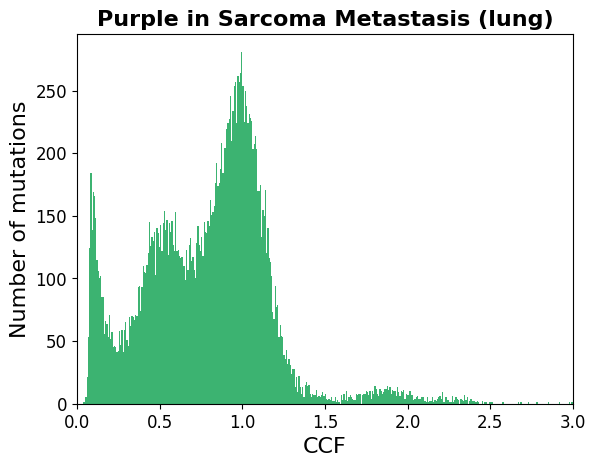

In [25]:
# Represent histogram without density plot

plt.hist(ccf.tolist(), bins = 500, color = "mediumseagreen")
plt.xlim([0,3])
plt.ylabel('Number of mutations', fontsize=16)
plt.xlabel('CCF', fontsize=16)
plt.title('Purple in Sarcoma Metastasis (lung)',fontsize=16, weight ='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show(ccf.tolist())

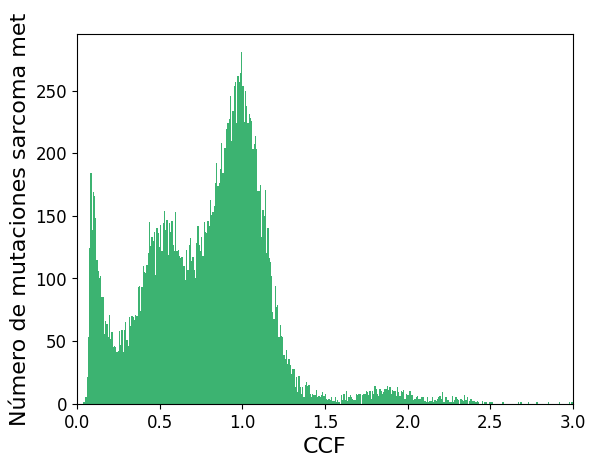

In [26]:
# Represent histogram without density plot

plt.hist(ccf.tolist(), bins = 500, color = "mediumseagreen")
plt.xlim([0,3])
plt.ylabel('Número de mutaciones sarcoma met', fontsize=16)
plt.xlabel('CCF', fontsize=16)
plt.title('     ',fontsize=16, weight ='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show(ccf.tolist())

/tmp/jobs/efiguerola/9388338/ipykernel_42213/1377778893.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ccf, bins=200, color = 'green')


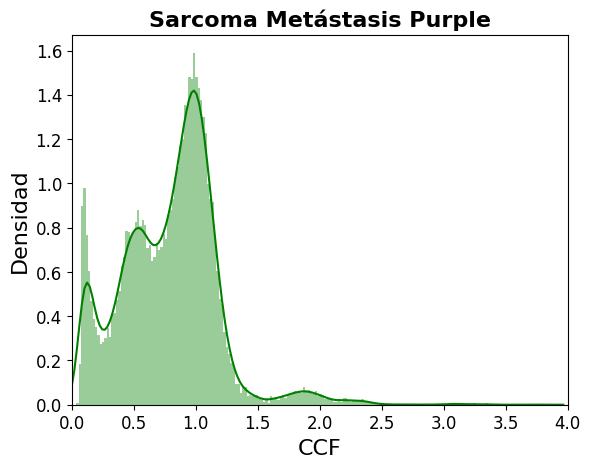

In [25]:
# Represent histogram with density plot to find the minimum 
ax = sns.distplot(ccf, bins=200, color = 'green')
plt.title('Sarcoma Metástasis Purple', fontsize=16, weight='bold')
plt.xlim([0,4])
plt.xlabel('CCF', fontsize=16)
plt.ylabel('Densidad', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Export image to directory
plt.savefig('/workspace/projects/sjd_melos/exports_images/density_ccf_lung.png',dpi=300,transparent=True, format='png', bbox_inches='tight')

# 5/ CCF threshold to obtain clonal mutations

In [26]:
# Extract graph data corresponding to x values and y values
ccf_x, ccf_y = ax.lines[0].get_data()
print(len(ccf_x),len(ccf_y)) #these returns 200, the number of bins used

200 200


In [27]:
# Find the range of x values where we set the threshold to find clonal mutations:
for threshold_x in ccf_x:
    range1 = 0.3 #check these values in x axis in CCF graph
    if  threshold_x > range1:
        print("This is the X threshold of clonal mutations:", threshold_x)
        break

This is the X threshold of clonal mutations: 0.30795408015628783


In [28]:
# Find the bin number where X threshold is set: 
for n in range(len(ccf_x)):
    if ccf_x[n] == threshold_x:
        print('This is the position (bin) where this value comes from:', n)

This is the position (bin) where this value comes from: 21


In [29]:
# Corroborate this position obtained returns the same value:
ccf_x[21]

0.30795408015628783

In [30]:
# Round the X threshold float number
round(threshold_x, 6) # 6 is the number of digits we want to obtain

0.307954

In [31]:
# The histogram of CCF has values sorted. So to find the position (bin) to cut-off clonal mutations values have to be sorted accordingly
ccf_sorted = ccf.sort_values(ascending=True)

In [32]:
# Obtain the CCF values greater than the threshold
ccf_clonal =[]
for i in ccf_sorted:
    if i > threshold_x:
        ccf_clonal.append(i)

In [33]:
# Check the minimum and maxiumum of filtered values
print(min(ccf_clonal))
print(max(ccf_clonal))

0.30799562043795614
3.8049325443786977


In [34]:
# Define a function that adds if the mutation is clonal or subclonal to the mutations_cnv_df
def clonality(row):
    for i in ccf_clonal:
        if i == row['CCF']:
            return 'clonal'

mutations_cnv_df['clonality'] = mutations_cnv_df.progress_apply(clonality, axis=1)

  0%|          | 0/22125 [00:00<?, ?it/s]

In [35]:
mutations_cnv_df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut,CN,CCF,clonality
0,chr1,104188,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=40,144|18,33;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:124,0:7.177e-03:124:33,0:29,0:124,0:0|1:10...",...,60,124,0.459459,SNV,Mutect_Strelka,sarcoma_lung,chr1_104188_C_A,1.1331,0.750343,clonal
1,chr1,843320,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=81,70|44,36;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:126,0:7.857e-03:126:58,0:63,0:125,0:67,59,0,0",...,25,126,0.761905,SNV,Mutect_Strelka,sarcoma_lung,chr1_843320_G_A,1.1331,1.244267,clonal
2,chr1,1118520,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=114,133|12,30...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.470e-03:153:62,0:83,0:152,0:78,75,0,0",...,94,153,0.308824,SNV,Mutect_Strelka,sarcoma_lung,chr1_1118520_C_T,1.1331,0.504340,clonal
3,chr1,1136548,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=72,93|44,38;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:123,0:8.107e-03:123:60,0:59,0:121,0:57,66,0,0",...,42,123,0.661290,SNV,Mutect_Strelka,sarcoma_lung,chr1_1136548_G_T,1.1331,1.079953,clonal
4,chr1,1182738,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=126,126|27,25...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:167,0:5.950e-03:167:85,0:68,0:165,0:84,83,0,0",...,85,167,0.379562,SNV,Mutect_Strelka,sarcoma_lung,chr1_1182738_C_T,1.1331,0.619863,clonal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22120,chrY,26654389,.,A,G,327,PASS,RC=GGAGAGGAAT;RC_IDX=6;RC_LF=GTAATGGAGT;RC_NM=...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:57,0:0:58:2084,0:63,0:0,0,0,0,0,57,58:0:...",...,15,57,0.559000,SNV,Strelka_SAGE,sarcoma-lung,chrY_26654389_A_G,0.4622,0.537870,clonal
22121,chrY,56823266,.,G,A,314,PASS,LPS=5879;LPS_RC=16;RC=CAATTTTC;RC_IDX=2;RC_LF=...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:460,0:0:460:14466,0:491,0:0,0,0,0,0,460,...",...,398,460,0.085000,SNV,Mutect_SAGE,sarcoma-lung,chrY_56823266_G_A,0.4622,0.081787,None
22122,chrY,56842066,.,CT,AC,1241,PASS,LPS=5882;LPS_RC=57;RC=ACACACAG;RC_IDX=2;RC_LF=...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:290,0:0:290:9437,0:306,0:0,0,0,0,0,290,2...",...,134,290,0.330000,MNV,Mutect_SAGE,sarcoma-lung,chrY_56842066_CT_AC,0.4622,0.317526,clonal
22123,chrY,56842087,.,T,C,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=213,218|33,30...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:295,0:3.303e-03:295:143,0:125,0:295,0:1|0:...",...,136,295,0.316583,SNV,Mutect_Strelka,sarcoma_lung,chrY_56842087_T_C,0.4622,0.304616,None


In [36]:
# Fill "None" values from 'clonality' column with "subclonal"
mutations_cnv_df['clonality'].fillna(value='subclonal', inplace = True)
display(mutations_cnv_df)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut,CN,CCF,clonality
0,chr1,104188,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=40,144|18,33;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:124,0:7.177e-03:124:33,0:29,0:124,0:0|1:10...",...,60,124,0.459459,SNV,Mutect_Strelka,sarcoma_lung,chr1_104188_C_A,1.1331,0.750343,clonal
1,chr1,843320,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=81,70|44,36;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:126,0:7.857e-03:126:58,0:63,0:125,0:67,59,0,0",...,25,126,0.761905,SNV,Mutect_Strelka,sarcoma_lung,chr1_843320_G_A,1.1331,1.244267,clonal
2,chr1,1118520,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=114,133|12,30...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.470e-03:153:62,0:83,0:152,0:78,75,0,0",...,94,153,0.308824,SNV,Mutect_Strelka,sarcoma_lung,chr1_1118520_C_T,1.1331,0.504340,clonal
3,chr1,1136548,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=72,93|44,38;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:123,0:8.107e-03:123:60,0:59,0:121,0:57,66,0,0",...,42,123,0.661290,SNV,Mutect_Strelka,sarcoma_lung,chr1_1136548_G_T,1.1331,1.079953,clonal
4,chr1,1182738,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=126,126|27,25...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:167,0:5.950e-03:167:85,0:68,0:165,0:84,83,0,0",...,85,167,0.379562,SNV,Mutect_Strelka,sarcoma_lung,chr1_1182738_C_T,1.1331,0.619863,clonal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22120,chrY,26654389,.,A,G,327,PASS,RC=GGAGAGGAAT;RC_IDX=6;RC_LF=GTAATGGAGT;RC_NM=...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:57,0:0:58:2084,0:63,0:0,0,0,0,0,57,58:0:...",...,15,57,0.559000,SNV,Strelka_SAGE,sarcoma-lung,chrY_26654389_A_G,0.4622,0.537870,clonal
22121,chrY,56823266,.,G,A,314,PASS,LPS=5879;LPS_RC=16;RC=CAATTTTC;RC_IDX=2;RC_LF=...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:460,0:0:460:14466,0:491,0:0,0,0,0,0,460,...",...,398,460,0.085000,SNV,Mutect_SAGE,sarcoma-lung,chrY_56823266_G_A,0.4622,0.081787,subclonal
22122,chrY,56842066,.,CT,AC,1241,PASS,LPS=5882;LPS_RC=57;RC=ACACACAG;RC_IDX=2;RC_LF=...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:290,0:0:290:9437,0:306,0:0,0,0,0,0,290,2...",...,134,290,0.330000,MNV,Mutect_SAGE,sarcoma-lung,chrY_56842066_CT_AC,0.4622,0.317526,clonal
22123,chrY,56842087,.,T,C,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=213,218|33,30...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:295,0:3.303e-03:295:143,0:125,0:295,0:1|0:...",...,136,295,0.316583,SNV,Mutect_Strelka,sarcoma_lung,chrY_56842087_T_C,0.4622,0.304616,subclonal


In [37]:
# PRIOR TO EXPORT TABLE CHECK IF THEY ARE DUPLICATED ROWS!
# Just in case, apply this function to drop duplicated rows according to CHROM, POS, REF, ALT columns
mutations_cnv_df = mutations_cnv_df.drop_duplicates(subset=['CHROM','POS','REF','ALT'])

In [38]:
mutations_cnv_df.shape

(22125, 27)

In [39]:
# Save this table as new table tsv.gz
mutations_cnv_df.to_csv('/workspace/projects/sjd_melos/MAFs_tables/Lung_CCF_Purple_all_mutations.tsv.gz', sep ='\t', index=None, compression = "gzip")

In [37]:
# Extract the list of clonal mutations in a new table
mutations_clonal_df = mutations_cnv_df[mutations_cnv_df['clonality'] == 'clonal']

In [38]:
mutations_clonal_df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut,CN,CCF,clonality
0,chr1,104188,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=40,144|18,33;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:124,0:7.177e-03:124:33,0:29,0:124,0:0|1:10...",...,60,124,0.459459,SNV,Mutect_Strelka,sarcoma_lung,chr1_104188_C_A,1.1331,0.750343,clonal
1,chr1,843320,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=81,70|44,36;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:126,0:7.857e-03:126:58,0:63,0:125,0:67,59,0,0",...,25,126,0.761905,SNV,Mutect_Strelka,sarcoma_lung,chr1_843320_G_A,1.1331,1.244267,clonal
2,chr1,1118520,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=114,133|12,30...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.470e-03:153:62,0:83,0:152,0:78,75,0,0",...,94,153,0.308824,SNV,Mutect_Strelka,sarcoma_lung,chr1_1118520_C_T,1.1331,0.504340,clonal
3,chr1,1136548,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=72,93|44,38;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:123,0:8.107e-03:123:60,0:59,0:121,0:57,66,0,0",...,42,123,0.661290,SNV,Mutect_Strelka,sarcoma_lung,chr1_1136548_G_T,1.1331,1.079953,clonal
4,chr1,1182738,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=126,126|27,25...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:167,0:5.950e-03:167:85,0:68,0:165,0:84,83,0,0",...,85,167,0.379562,SNV,Mutect_Strelka,sarcoma_lung,chr1_1182738_C_T,1.1331,0.619863,clonal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22116,chrY,26425520,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=37,37|14,13;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:63,0:0.016:63:25,0:31,0:60,0:29,34,0,0",...,11,63,0.710526,SNV,Mutect_Strelka,sarcoma_lung,chrY_26425520_G_A,0.4622,0.683668,clonal
22117,chrY,26453335,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=34,55|17,18;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:75,0:0.013:75:44,0:28,0:73,0:29,46,0,0",...,14,75,0.714286,SNV,Mutect_Strelka,sarcoma_lung,chrY_26453335_G_T,0.4622,0.687286,clonal
22118,chrY,26568173,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=44,42|16,13;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:74,0:0.014:74:36,0:29,0:71,0:39,35,0,0",...,12,74,0.707317,SNV,Mutect_Strelka,sarcoma_lung,chrY_26568173_C_A,0.4622,0.680580,clonal
22120,chrY,26654389,.,A,G,327,PASS,RC=GGAGAGGAAT;RC_IDX=6;RC_LF=GTAATGGAGT;RC_NM=...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:57,0:0:58:2084,0:63,0:0,0,0,0,0,57,58:0:...",...,15,57,0.559000,SNV,Strelka_SAGE,sarcoma-lung,chrY_26654389_A_G,0.4622,0.537870,clonal


In [39]:
# PRIOR TO EXPORT TABLE CHECK IF THEY ARE DUPLICATED ROWS!
# Just in case, apply this function to drop duplicated rows according to CHROM, POS, REF, ALT columns
mutations_clonal_df = mutations_clonal_df.drop_duplicates(subset=['CHROM','POS','REF','ALT'])

In [40]:
# See that there were 2 rows duplicated!
mutations_clonal_df.shape 

(19501, 27)

In [41]:
# Save this table as new table tsv.gz
mutations_clonal_df.to_csv('/workspace/projects/sjd_melos/MAFs_tables/Lung_CCF_Purple_clonal_mutations.tsv.gz', sep ='\t', index=None, compression = "gzip")